<a href="https://colab.research.google.com/github/jwgdmkj/jupiterColab/blob/master/GANProduction_1213.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
#Gan With Pytorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader as DL
from torchvision import datasets, transforms

from torchvision.utils import save_image
import numpy as np
import os, sys
from matplotlib.pyplot import imshow, imsave

MODEL_NAME = 'GAN'
n_noise = 100
batch_size = 100

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize(mean = [0.5], std = [0.5])])
#numpy array를 mean값이 0.5, std값이 0.5로 정규화된 tensor로 변환하도록 하는 함수

#위의 transform형태의 함수를 지정했으니, mnist를 받을 때 데이터는 위의 방식으로 전처리됨
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
data_loader = DL(dataset=mnist, batch_size=batch_size, 
                         shuffle=True, drop_last=True)

if not os.path.exists('samples'):
    os.makedirs('samples')

In [36]:
def get_sample_IMAGE(G, n_noise) :
  z = torch.randn(batch_size, n_noise)
  y_hat = G(z).view(batch_size, 28, 28) # (batch_size, 28, 28)로 tensor 모양 변환
  result = y_hat.cpu().data.numpy()   # cpu 안 data를 numpy로 가져온다.
  img = np.zeros([280, 280])          # [280,280] 행렬을 0으로 초기화

  #numpy 로 가져온 data들을 concatenate해서 우리가 쓰는 img로 만듬(dimension 더하기)
  for j in range(10):                           
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1) 
  return img  

Step: 0, D_Loss: [1.4130996], G_Loss: [0.7366304]
Step: 500, D_Loss: [1.3861914], G_Loss: [0.97393394]
Step: 1000, D_Loss: [1.1967685], G_Loss: [1.125296]
Step: 1500, D_Loss: [1.3026636], G_Loss: [0.805397]
Step: 2000, D_Loss: [1.4028134], G_Loss: [0.53877044]
Step: 2500, D_Loss: [1.2430387], G_Loss: [0.87729174]
Step: 3000, D_Loss: [1.1559069], G_Loss: [1.1463246]
Step: 3500, D_Loss: [1.2666469], G_Loss: [0.7571248]
Step: 4000, D_Loss: [1.2075698], G_Loss: [0.889161]
Step: 4500, D_Loss: [1.2969725], G_Loss: [0.59258825]
Step: 5000, D_Loss: [1.2584693], G_Loss: [1.1151752]
Step: 5500, D_Loss: [1.228617], G_Loss: [0.85499275]
Step: 6000, D_Loss: [1.2739571], G_Loss: [0.670623]
Step: 6500, D_Loss: [1.3326135], G_Loss: [1.1451002]
Step: 7000, D_Loss: [1.3278933], G_Loss: [0.9356927]
Step: 7500, D_Loss: [1.2594897], G_Loss: [0.89728683]
Step: 8000, D_Loss: [1.2147329], G_Loss: [0.900666]
Step: 8500, D_Loss: [1.2854252], G_Loss: [0.85903305]
Step: 9000, D_Loss: [1.3146749], G_Loss: [0.73688

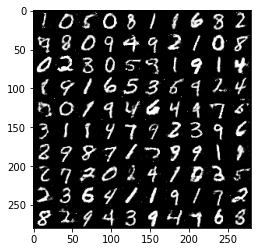

In [38]:
class Discriminator(nn.Module):
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),        #input -> 512의 dimension으로 변환
            nn.LeakyReLU(0.2),                 # ReLU는 0보다 작으면 0으로 출력하지만 LeakyReLU는 0.2x로 출력을 한다.
            nn.Linear(512, 256),               # 512->256으로 변환
            nn.LeakyReLU(0.2), 
            nn.Linear(256, num_classes),       # 256 -> 지정한 class 개수 dimension으로 변환
            nn.Sigmoid(),                      # 함수값을 [0, 1]로 제한하고 0과 1만을 구별하는 것(binary classification)에서 효과적이다.
        )
    
    def forward(self, x):
        y = x.view(x.size(0), -1)
        y = self.layer(y)
        return y

class Generator(nn.Module):
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),       #input -> 128의 dimension으로 변환
            nn.LeakyReLU(0.2), 
            nn.Linear(128, 256),      
            nn.BatchNorm1d(256),              # feaure들이 layer을 지나갈 수록 서로 다른 분포가 생기거나 batch별로 서로 다른 분포가 생기는 것을 방지하기 위하여 batch 별로 normalization해준다.
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),     
            nn.Tanh()                         # Tanh 함수는 함수값을 [-1, 1]로 제한시켜 값을 saturate 시킨다는 점에서 sigmoid와 비슷하나 zero-centered 모양이다.
        )                                     
        
    def forward(self, x):
        y = self.layer(x)
        y = y.view(x.size(0), 1, 28, 28)
        return y

criterion = nn.BCELoss()                                               # class 가 두개인 경우 효과적인 BCELoss를 사용
D = Discriminator()
G = Generator(n_noise)  

D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))  # SGD에서 효과적인 momentum과 방향설정으로 효율적으로 gradient를 조절하는 기법인 Adam 사용
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

max_epoch = 50
step = 0
n_critic = 1

D_labels = torch.ones(batch_size, 1)                  # batch size만큼 1으로 채워진 tensor 생성
D_fakes = torch.zeros(batch_size, 1)                  # batch size만큼 0으로 채워진 tensor 생성

for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):    # data_loader에서 index에 따른 images 값을 받아 for 문 구동
        # Training Discriminator
        x = images
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)     # 원래의 image와 D_labels 값의 loss function을 구한다.

        z = torch.randn(batch_size, n_noise)          # 정규 분포 난수값으로 구성된 (batch_size) X (n_noise) 를 생성
        z_outputs = D(G(z))                           # generative 한 모델을 discriminative한 값을 구한다.
        D_z_loss = criterion(z_outputs, D_fakes)      # 구한 값과 fake image의 loss function을 구한다.
        D_loss = D_x_loss + D_z_loss                  
        
        D.zero_grad()                                 # gradients 값들을 backpropagation 과정에서 계속 더해지기 때문에 그 때마다 0으로 만들어주는 것이 학습하기에 편리하다.
        D_loss.backward()                             # loss를 최소화 시키기 위하여 backpropagation이 필요하고 이때의 방법으로 loss.backward()사용했다. 
        D_opt.step()                                  # 학습을 진행할때마다 parameter들을 갱신한다.

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise)      # 정규 분포 난수값으로 구성된 (batch_size) X (n_noise) 를 생성 
            z_outputs = D(G(z))                       # generative 한 모델을 discriminative한 값을 구한다.
            G_loss = criterion(z_outputs, D_labels)   # fake image를 분류한 값과 D_labels 값의 loss function을 구한다.

            G.zero_grad()                             # gradients 값들을 backpropagation 과정에서 계속 더해지기 때문에 그 때마다 0으로 만들어주는 것이 학습하기에 편리하다.
            G_loss.backward()                         # loss를 최소화 시키기 위하여 backpropagation이 필요하고 이때의 방법으로 loss.backward()사용했다. 
            G_opt.step()                              # 학습을 진행할때마다 parameter들을 갱신한다.
        
        if step % 500 == 0:
            print('Step: {}, D_Loss: {}, G_Loss: {}'.format(step, D_loss.detach().numpy().flatten(), G_loss.detach().numpy().flatten()))  # cpu에 저장된 data를 가져오기 위해 detach 사용, 출력 값을 정렬하기 위해 flatten 사용
        
        if step % 1000 == 0:
            G.eval()
            img = get_sample_IMAGE(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')  #sample 경로에 저장
            G.train()
        step += 1
G.eval()
imshow(get_sample_IMAGE(G, n_noise), cmap='gray') # 이미지 plot